#  Анализ маркетинга приложения Procrastinate Pro+

Мы проводим исследование для развлекательного приложения Procrastinate Pro+. В последние несколько месяцев компания тратит большие суммы на рекламу, но она не окупается, что приводит компанию к убыткам.

**Цель** - разобраться в причинах, по которым компания терпит убытки последние несколько месяцев, и предложить рекомендации по улучшению ситуации.
    
**Ход исследования:**
 - Ознакомимся с данными, подготовим их к исследованию.
 - Построим профили пользователей и проведите исследовательский анализ данных в разбивке по странам, устройствам и каналам привлечения.
 - Узнаем, какой бюджет был потрачен на рекламу в общем, какие каналы были самыми дорогими и насколько реклама была эффективна.
 - Оценим окупаемость рекламных каналов в разбивке по странам, устройствам и каналам привлечения.
 - Соберем общий вывод и предложим полезные рекомендации для бизнеса.
 
**Описание данных:**

*Таблица visits_log_short (лог сервера с информацией о посещениях сайта):*\

`User Id` — уникальный идентификатор пользователя\
`Device` — категория устройства пользователя\
`Session start` — дата и время начала сессии\
`Session End` — дата и время окончания сессии\
`Channel` — идентификатор рекламного источника, из которого пришел пользователь\
`Region` - страна пользователя\
\
*Таблица orders_log_short (информация о заказах):*\
\
`User Id` — уникальный id пользователя, который сделал заказ\
`Event Dt` — дата и время покупки\
`Revenue` — выручка\
\
*Таблица costs_short (информация о затратах на маркетинг):*\
\
`Channel` — идентификатор рекламного источника\
`Dt` — дата\
`Costs` — затраты на этот рекламный источник в этот день\

## 1. Загрузим данные и подготовим их к анализу
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный.

In [1]:
# импортируем библиотеки, неободимые для анализа
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings

In [2]:
visits, orders, costs = (
    pd.read_csv('/Users/polinamokretsova/visits_info_short.csv'), # данные о визитах сайта
    pd.read_csv('/Users/polinamokretsova/orders_info_short.csv'), # данные о заказах/покупках
    pd.read_csv('/Users/polinamokretsova/costs_info_short.csv'), # данные о расходах на рекламу
)

In [3]:
# посмотрим общую информацию о датафрэймах
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

In [4]:
# приведем названия всех столбцов в датафрэйме к змеиному регистру
visits.columns = visits.columns.str.lower() 
orders.columns = orders.columns.str.lower() 
costs.columns = costs.columns.str.lower() 

# переимениуем столбцы по правилам хорошего стиля
visits.rename(
    columns={'user id':'user_id', 'session start':'session_start', 'session end':'session_end'},
    inplace = True)

orders.rename(
    columns={'user id':'user_id', 'event dt':'event_dt'},
    inplace = True)

In [5]:
# заменим типы данных тех переменных, где это необходимо
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [6]:
visits.duplicated().sum()

0

In [7]:
orders.duplicated().sum()

0

In [8]:
costs.duplicated().sum()

0

**На этом шаге исследования мы подготовили данные к анализу:**
* Ознакомились с данными.
* Привели названия столбцов к красивому и удобному виду.
* Изменили типы данных у переменных, в которых хранится информация о времени.
* Проверили данных на дубликаты - их не обнаружено.

## 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии и для визуализации

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Добавим функции для визуализации метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().**

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## 3. Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [16]:
# введём функцию для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [17]:
# построим профили пользователей
profiles = get_profiles(visits, orders, costs, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [18]:
profiles['dt'] = pd.to_datetime(profiles['dt'])
profiles['month'] = pd.to_datetime(profiles['month'])

In [19]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  datetime64[ns]
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 10.4+ MB


**Определим минимальную и максимальную дату привлечения пользователей.**

In [20]:
dt_min = profiles.sort_values(by='dt').agg({'dt': 'min'}) # минимальная дата
dt_max = profiles.sort_values(by='dt').agg({'dt': 'max'}) # максимальная дата
display(dt_min,dt_max)

dt   2019-05-01
dtype: datetime64[ns]

dt   2019-10-27
dtype: datetime64[ns]

Минимальная дата привлечения людей пользователей: **2019-05-01**\
Максимальная дата привлечения людей пользователей: **2019-10-27**   

**Узнаем, из каких стран приходят посетители и какие страны дают больше всего платящих пользователей.**

In [21]:
# посмотрим, из каких стран приходят посетители
countries_users = profiles.groupby('region').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
display(countries_users)

,user_id
region,
United States,100002
UK,17575
France,17450
Germany,14981


In [22]:
# посмотрим, из каких стран приходит больше платящих пользователей

paying_users = profiles.query('payer == True') # введем переменную для платящих пользователей

# соберем табличку, чтобы узнать количество платящих пользователей по каждой стране
countries_paying_users = paying_users.groupby(['region','payer']).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)

# добавим в таблицу столбец с долями платящих пользователей 
countries_paying_users['share_of_paying_users'] = countries_paying_users['user_id']/countries_users['user_id']*100

display(countries_paying_users)

,,user_id,share_of_paying_users
region,payer,,
United States,True,6902,6.901862
UK,True,700,3.982930
France,True,663,3.799427
Germany,True,616,4.111875


По расчетам видно, что США - абсолютный лидер как по количеству уникальных посетителей в общем (100к), так и по количеству платящих пользователей (доля платящих - 6,9%). У Великобритании, Франции и Германии показатели ниже: количество униклальных пользователей в сумме находится в диапазоне от 15 до 17,6к пользователей, а доли платящих пользователей в диапазоне от 3,8 до 4,1%.

**Посмотрим, какими устройствами они пользуются и с каких устройств чаще всего заходят платящие пользователи?**

In [23]:
# посмотрим, какими устройствами пользуются посетители
device_users = profiles.groupby('device').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
display(device_users)

,user_id
device,
iPhone,54479
Android,35032
PC,30455
Mac,30042


In [24]:
# соберем табличку, чтобы узнать количество платящих пользователей по каждому устройству
device_paying_users = paying_users.groupby(['device','payer']).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)

# добавим в таблицу столбец с долями платящих пользователей 
device_paying_users['share_of_paying_users'] = device_paying_users['user_id']/device_users['user_id']*100

display(device_paying_users)

,,user_id,share_of_paying_users
device,payer,,
iPhone,True,3382,6.207897
Android,True,2050,5.851793
Mac,True,1912,6.364423
PC,True,1537,5.046790


Больше всего пользователей посещали сайт с iPhone (54,5к человек), количество платящих пользователей айфонов так же преобладает. Если смотреть по долям платящих, то на первое место выходят пользователи Mac.

**Опрелелим, по каким рекламным каналам шло привлечение пользователей и какие каналы приносят больше всего платящих пользователей.**

In [25]:
# посмотрим, по каким рекламным каналам шло привлечение пользователей
channel_users = profiles.groupby('channel').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
display(channel_users)

,user_id
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


In [26]:
# соберем табличку, чтобы узнать количество платящих пользователей по каждому каналу привлечения
channel_paying_users = paying_users.groupby(['channel','payer']).agg({'user_id':'nunique'})

# добавим в таблицу столбец с долями платящих пользователей 
channel_paying_users['share_of_paying_users'] = (channel_paying_users['user_id']/channel_users['user_id']*100)
channel_paying_users.sort_values(by='share_of_paying_users', ascending=False)

,,user_id,share_of_paying_users
channel,payer,,
FaceBoom,True,3557,12.204914
AdNonSense,True,440,11.340206
lambdaMediaAds,True,225,10.469986
TipTop,True,1878,9.600736
RocketSuperAds,True,352,7.913669
WahooNetBanner,True,453,5.296387
YRabbit,True,165,3.826531
MediaTornado,True,156,3.574702
LeapBob,True,262,3.063253


Большинство пользователей пришло на сайт органически (56к), платящих пользователей было больше всего привлечено с помощью канала Faceboom (12,2%). Меньше всего платящих пользователей, который пришли органически - это вполне нормально и ожидаемо. 

**На этом этапе анализа мы выяснили:**
* **Страны.** Пользователи приходят из США, Великобритании, Франции и Германии. Больше всего посетителей и платящих пользователей приходит из США (доля платящих там составляет 6,9%). У Великобритании, Франции и Германии показатели ниже: количество униклальных пользователей в сумме находится в диапазоне от 15 до 17,6к пользователей, а доли платящих пользователей в диапазоне от 3,8 до 4,1%.
* **Устройства.** Пользователи пользуются iPhone, Android, PC, Mac. По количеству платящих пользователей на первое место выходит iPhone, а если смотреть по долям платящих - Mac.
* **Рекламные каналы.** Всего 10 рекламных каналов было задействовано для привлечения пользователей, так же есть и органические пользователи. Большинство пользователей пришло на сайт органически (56к), платящих пользователей было больше всего привлечено с помощью канала Faceboom (12,2%). Меньше всего платящих пользователей, который пришли органически - это вполне нормально и ожидаемо. 

## 4. Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [27]:
# поссчитаем расходы на рекламу в сумме 

total_cost = costs['costs'].sum()
display(total_cost)

105497.30000000002

In [28]:
# поссчитаем расходы на рекламу на каждый источник

costs_channel = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
costs_channel['cost_perc'] = costs_channel['costs']/total_cost*100
display(costs_channel)

,costs,cost_perc
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


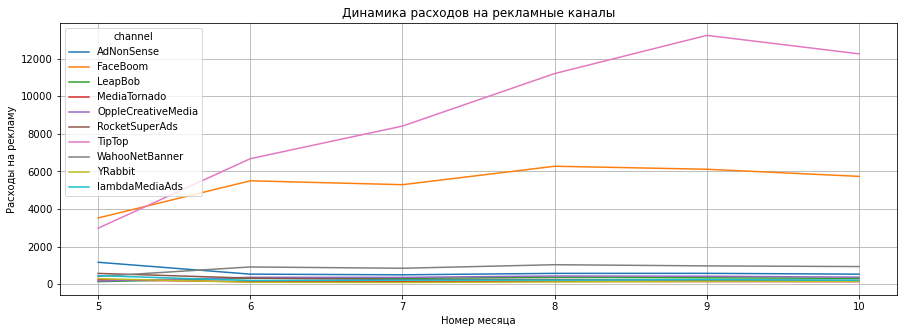

In [29]:
# визуализируем изменение метрик по времени

costs['month'] = pd.to_datetime(costs['dt']).dt.month 
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(15,5))
plt.xlabel('Номер месяца')
plt.ylabel('Расходы на рекламу')
plt.title('Динамика расходов на рекламные каналы')
plt.show()

Мы видим, что компания с мая по октябрь сделала упор на привлечение пользователей в TipTop (пик трат на рекламу заметен в сентябре – 13к), примерно 4-5к в среднем тратили на рекламу в Faceboom. Остальные рекламные каналы обошлись компании от 0 до 1к.

**Узнаем, сколько в среднем стоило привлечение одного покупателя из каждого источника**

In [30]:
# рассчитаем средний САС на одного пользователя для всего проекта и для каждого источника трафика

# исключим органических пользователей из каналов привлечения, так как они достались нам бесплатно
advertising_profiles = profiles[profiles['channel'] != 'organic'] 

# считаем средний САС на одного пользователя для всего проекта
cac_total = advertising_profiles['acquisition_cost'].mean()

# считаем средний САС для каждого источника трафика
cac_channel = advertising_profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values('acquisition_cost', ascending=False)

display(cac_total)
display(cac_channel)

1.127481323942928

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**При анализе маркетинга мы выяснили следующее ⬇️**

**В сумме на рекламу было потрачено:** 105497.\
**Больше всего расходов было на рекламный каналы:** TipTop (54751 - больше половины общего рекламного бюджета) и Faceboom (32445). С мая по октябрь компания делала упор на привлечение пользователей в TipTop (пик трат на рекламу заметен в сентябре – 13к), примерно 4-5к в среднем тратили на рекламу в Faceboom в течение этого периода. Остальные рекламные каналы обошлись компании гораздо дешевле (значит, и продвигались на них меньше).\
**Средняя стоимость привлечения клиента для всего проекта** – 1.1.\
**Средняя стоимость привлечения клиента** для TipTop - 2.8, FaceBoom - 1.1, AdNonSense - 1. У остальных рекламных каналов сумма меньше.



## 5. Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишием проблемы, которые вы обнаружили. Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишемвозможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### 5.1. Проанализируем общую окупаемость рекламы

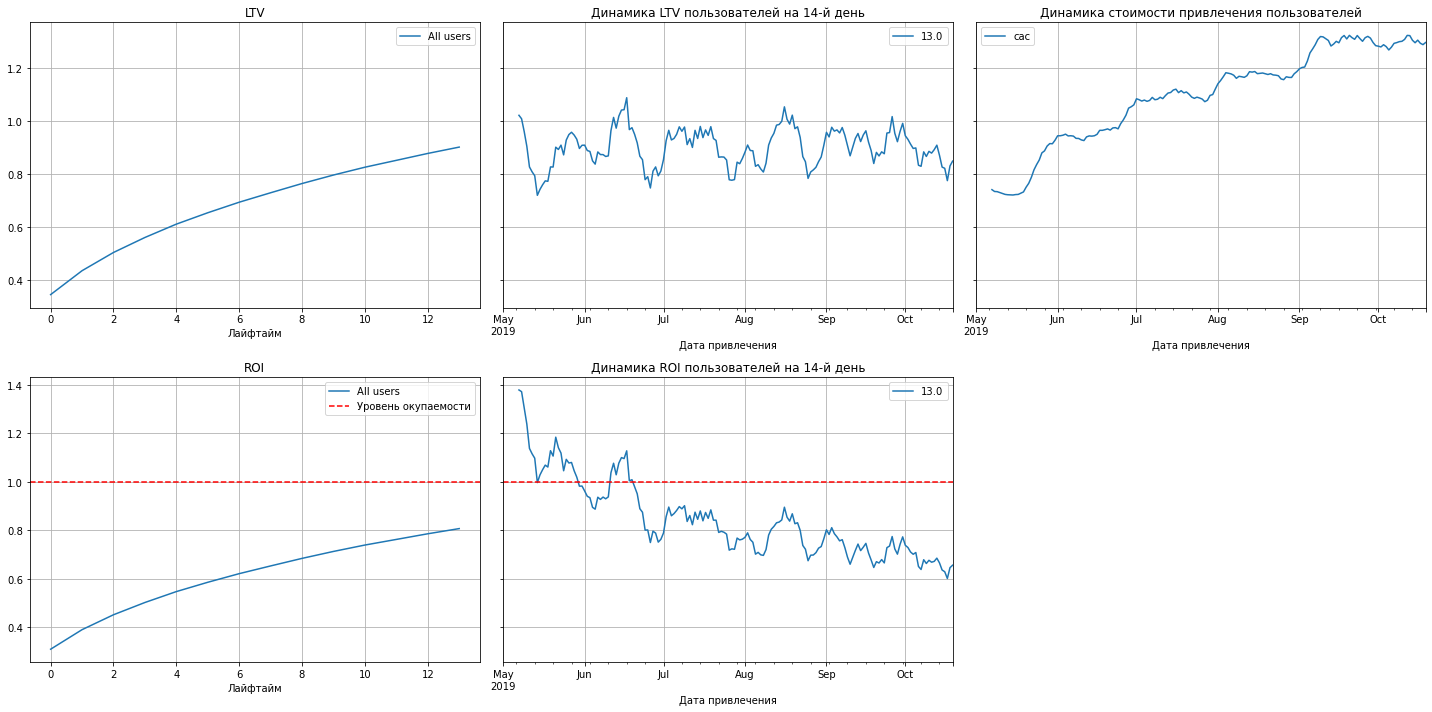

In [31]:
# рассчитаем и визуализируем LTV и ROI

observation_date = datetime(2019,11,1).date()
horizon_days = 14

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    advertising_profiles, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**По графикам можно сделать следующие выводы:**
1. Реклама не окупается. ROI к концу второй недели совсем немногим выше 80%.
2. САС стабильно увеличивается.
3. LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

Чтобы разобраться в причинах убытков компании, пройдём по всем доступным характеристикам пользователей — устройству, стране и источнику привлечения.

### 5.2. Проанализируем окупаемость рекламы с разбивкой по устройствам

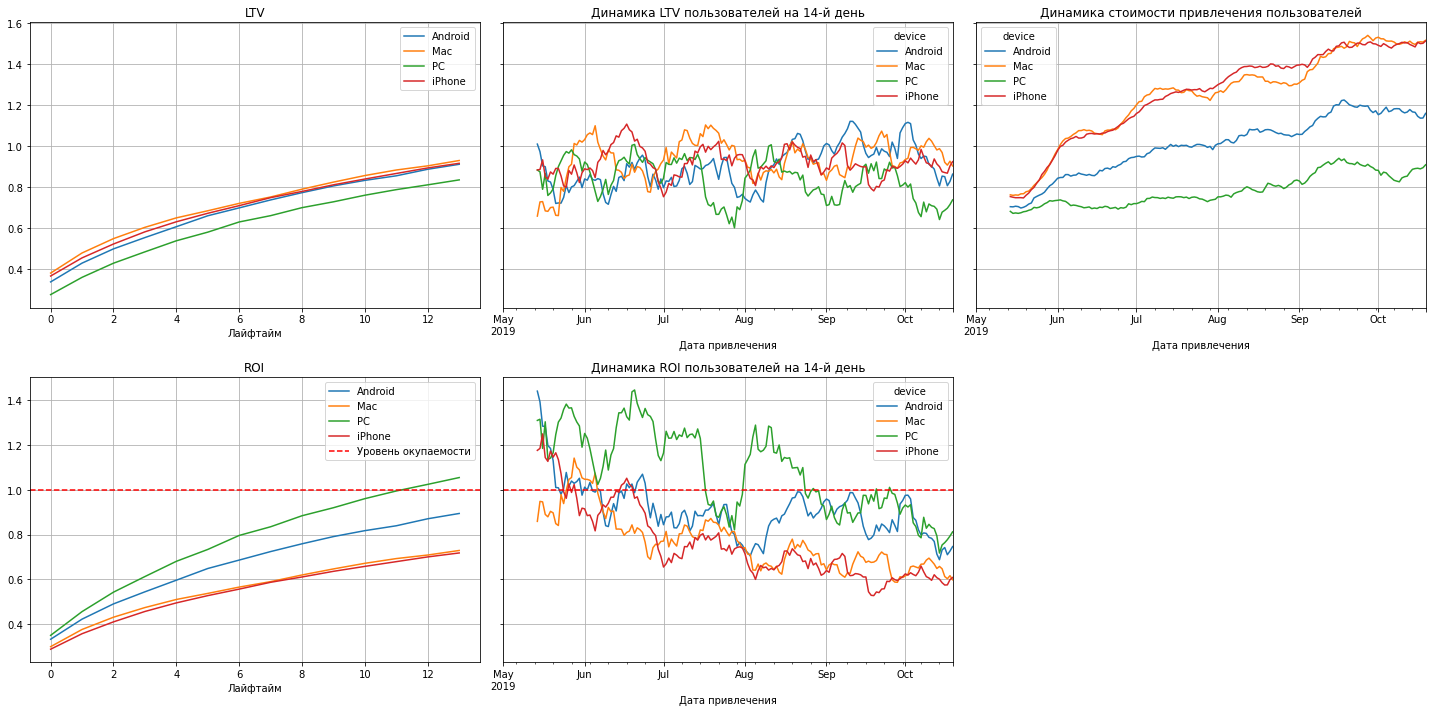

In [32]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    advertising_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из всех пользователей окупаются только пользователи PC. Показатели у пользователей iPhone и Mac хуже всего. При этом стоимость привлечения у них больше. Узнаем, в чём причина: в низкой конверсии или низком удержании.  

**Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion()**

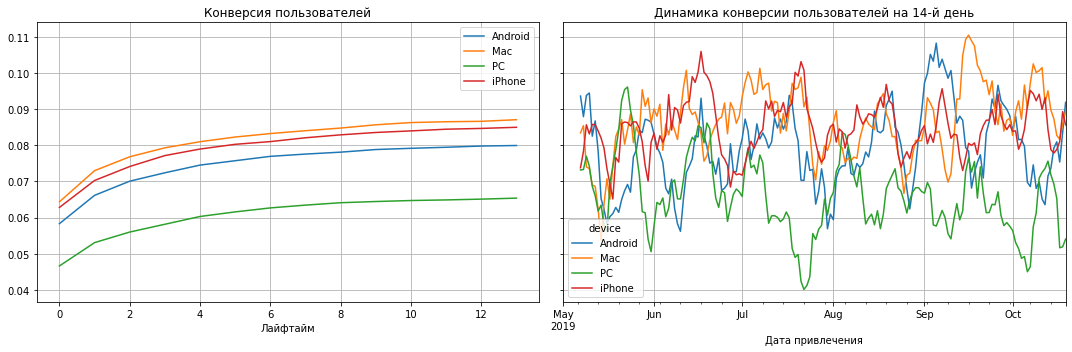

In [33]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    advertising_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи iPhone и Mac конвертируются хорошо и постоянно. Видимо, дело в удержании. 

**Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель**

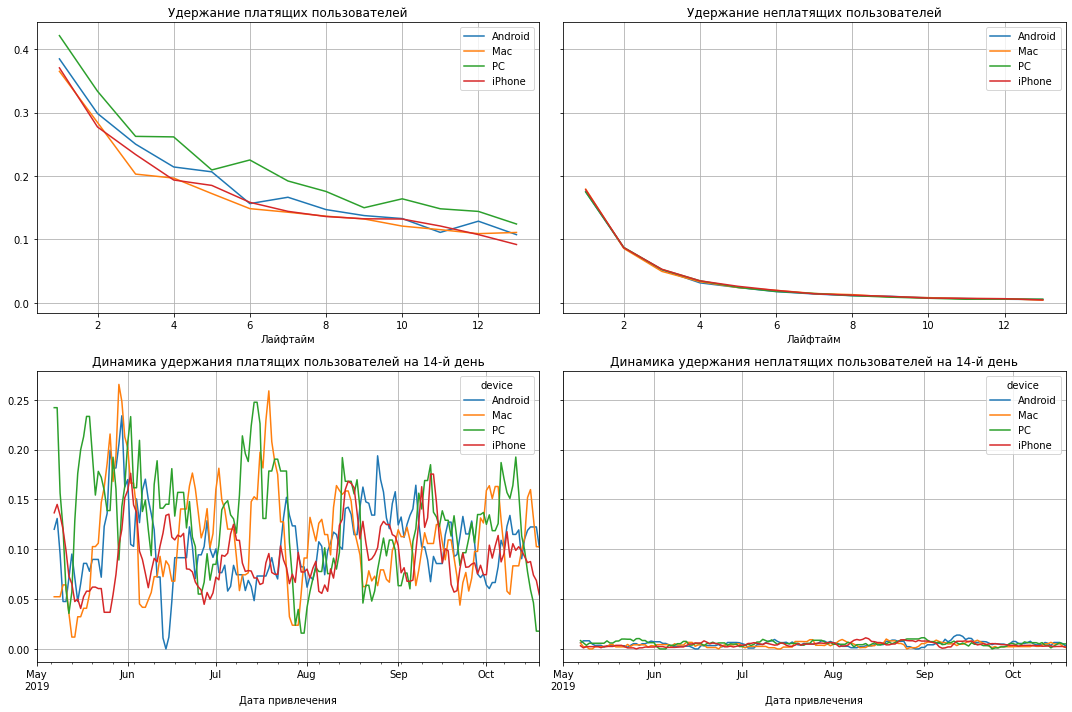

In [34]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    advertising_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей iPhone и Mac в основном хуже, чем пользователей других устройств. Возможно, дело в технических ошибках.

### 5.3. Проанализируем окупаемость рекламы с разбивкой по странам

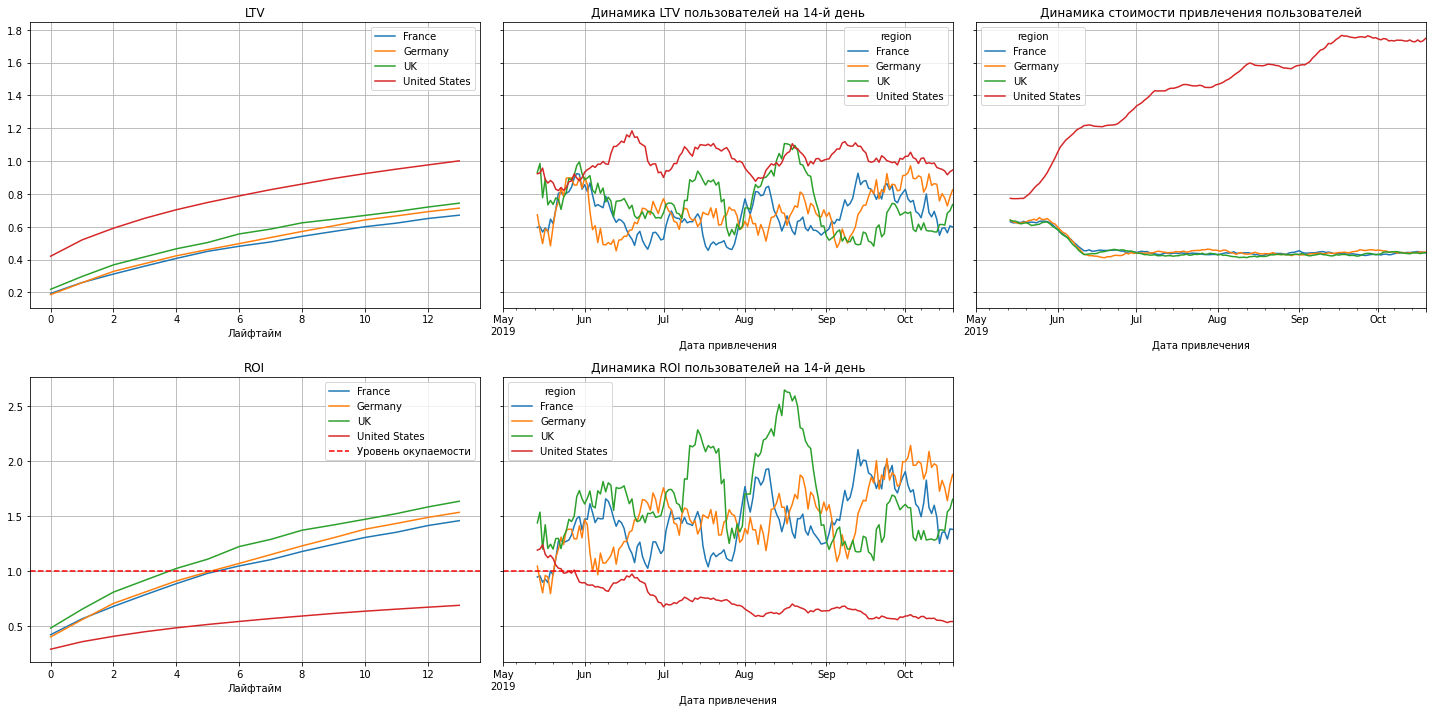

In [35]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    advertising_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Компания больше всего денег тратит на привлечение пользователей из США, но при этом затраты именно на этих пользователей не окупаются (в то время, как с пользователями из других стран картина совершенно другая, они там окупаются стабильно). При этом проблема не в качестве самих пользователей (их LTV стабилен).

**Изучим рекламу в США отдельно**

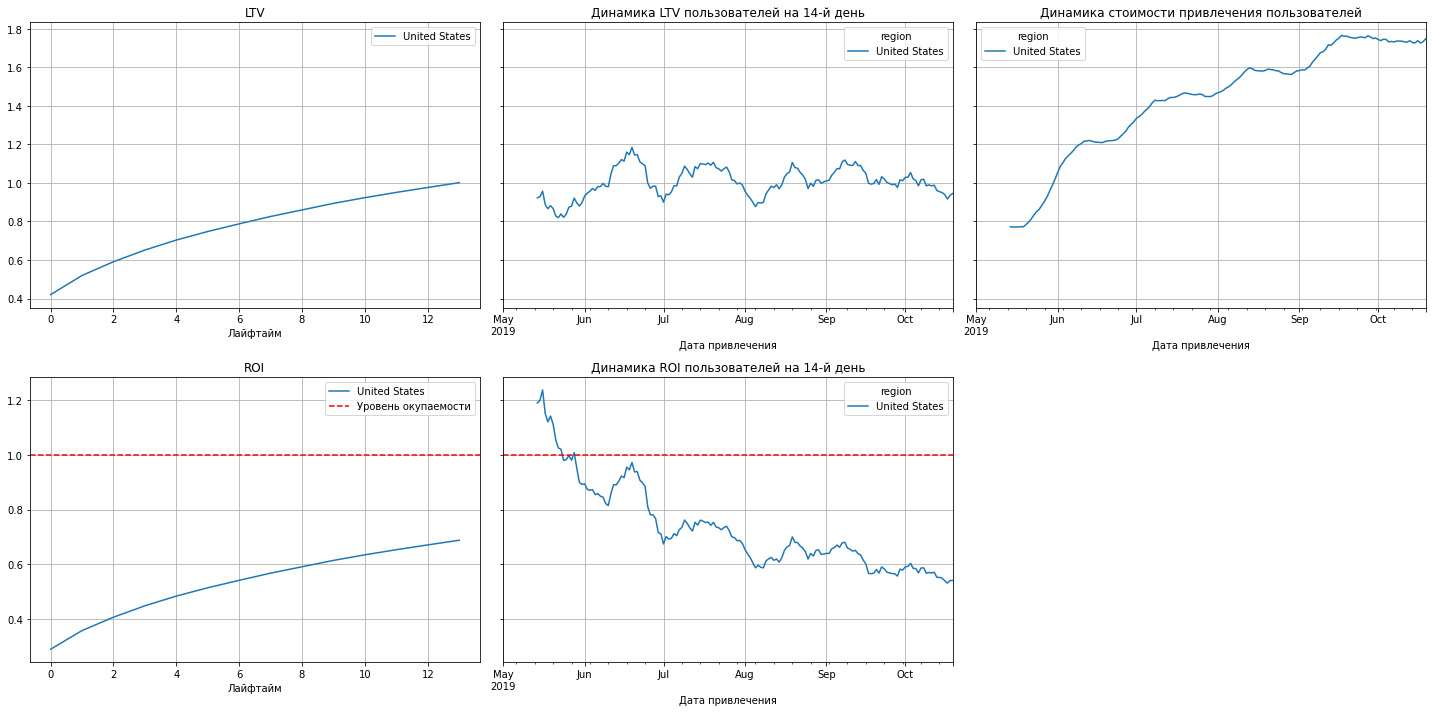

In [36]:
usa_users = advertising_profiles.query('region == "United States"') # выделяем в отдельный датафрэйм пользователей США

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_users, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Реклама в США не окупается. ROI на уровне 70%.

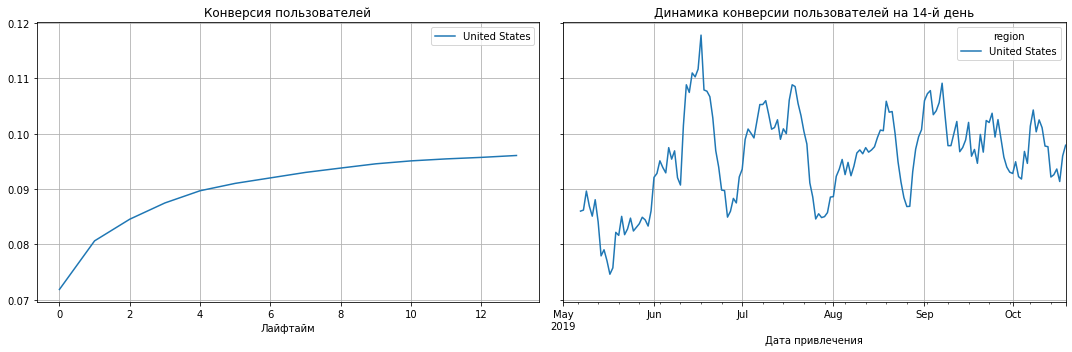

In [37]:
# смотрим конверсию пользователей США

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    usa_users, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

При этом конверсия пользователей хорошая. Проверим удержание.

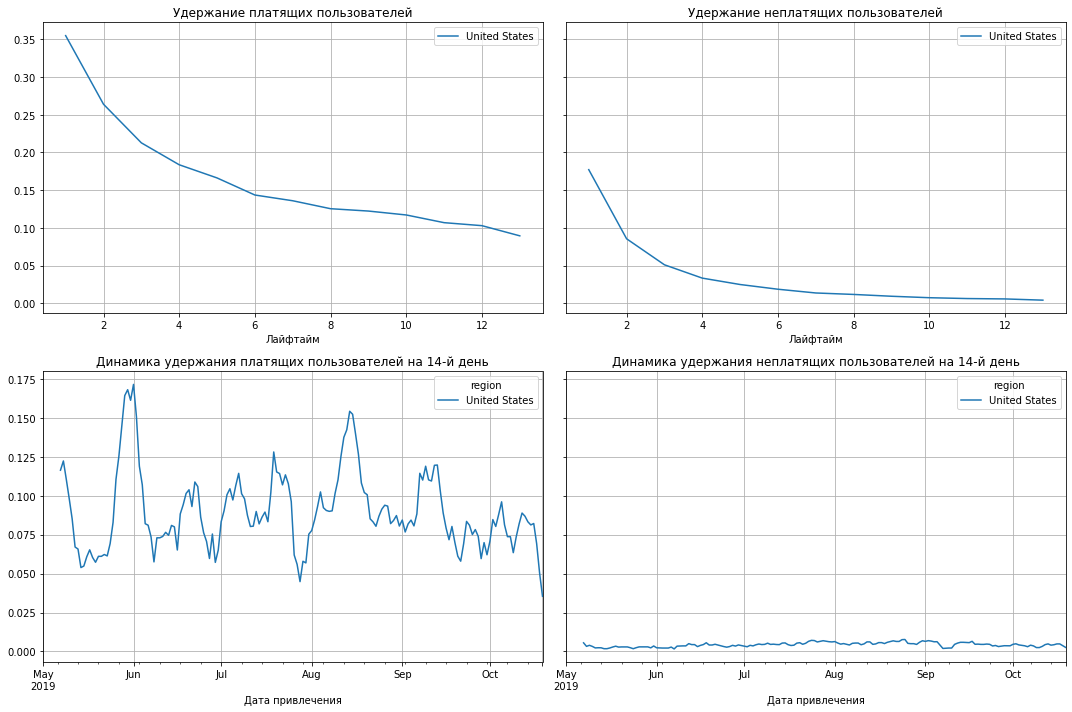

In [38]:
# смотрим удержание пользователей США

retention_raw, retention_grouped, retention_history = get_retention(
    usa_users, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Проблема явно кроется в удержании пользователей США. 

**Посчитаем и визуализируем конверсию в разбивке по всем странам**

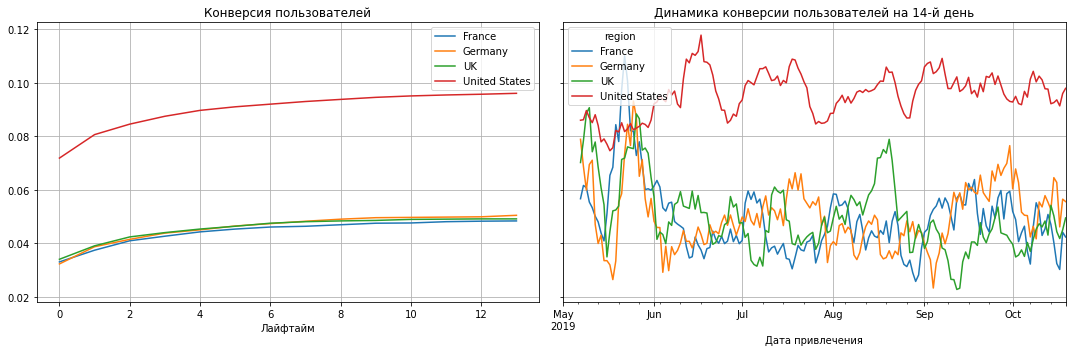

In [39]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    advertising_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи из США конвертируются стабильно лучше, чем пользователи других стран. Проверим удержание.

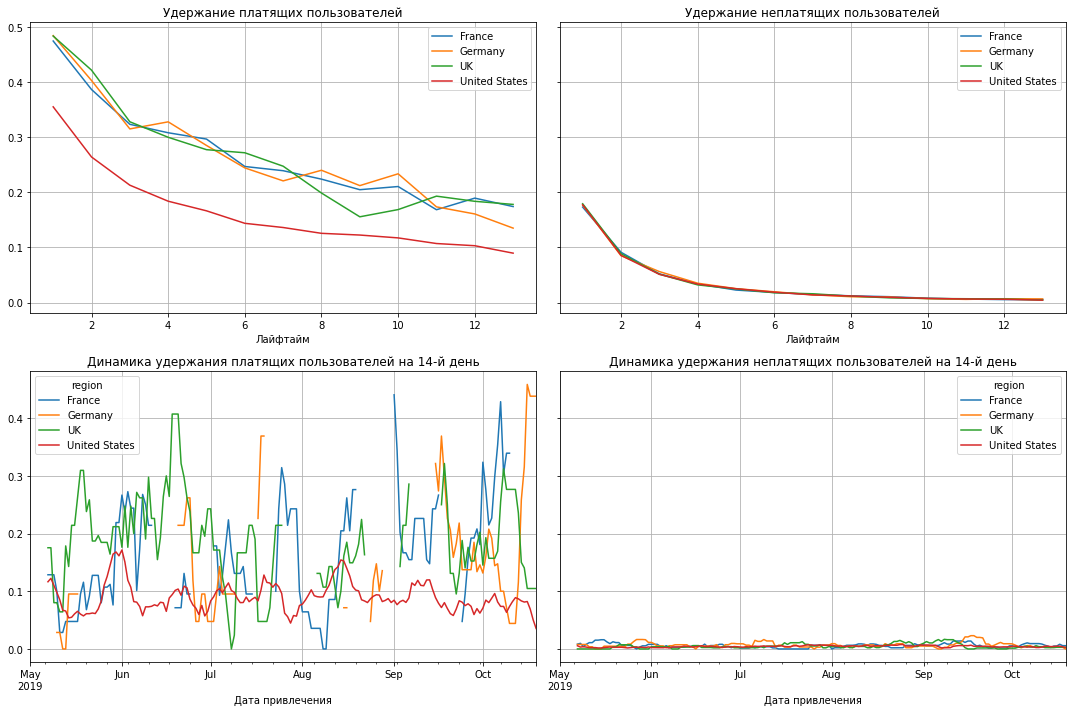

In [40]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    advertising_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

А вот удержание пользователей из США, как и предполагалось, заметно хуже пользователей остальных стран. Возможно, возникают технические ошибки - например, для пользования приложением необходимо произвести оплату, но оплата именно в этом регионе не проходит. Для более детального изучения нам необходим журнал событий.

### 5.4. Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

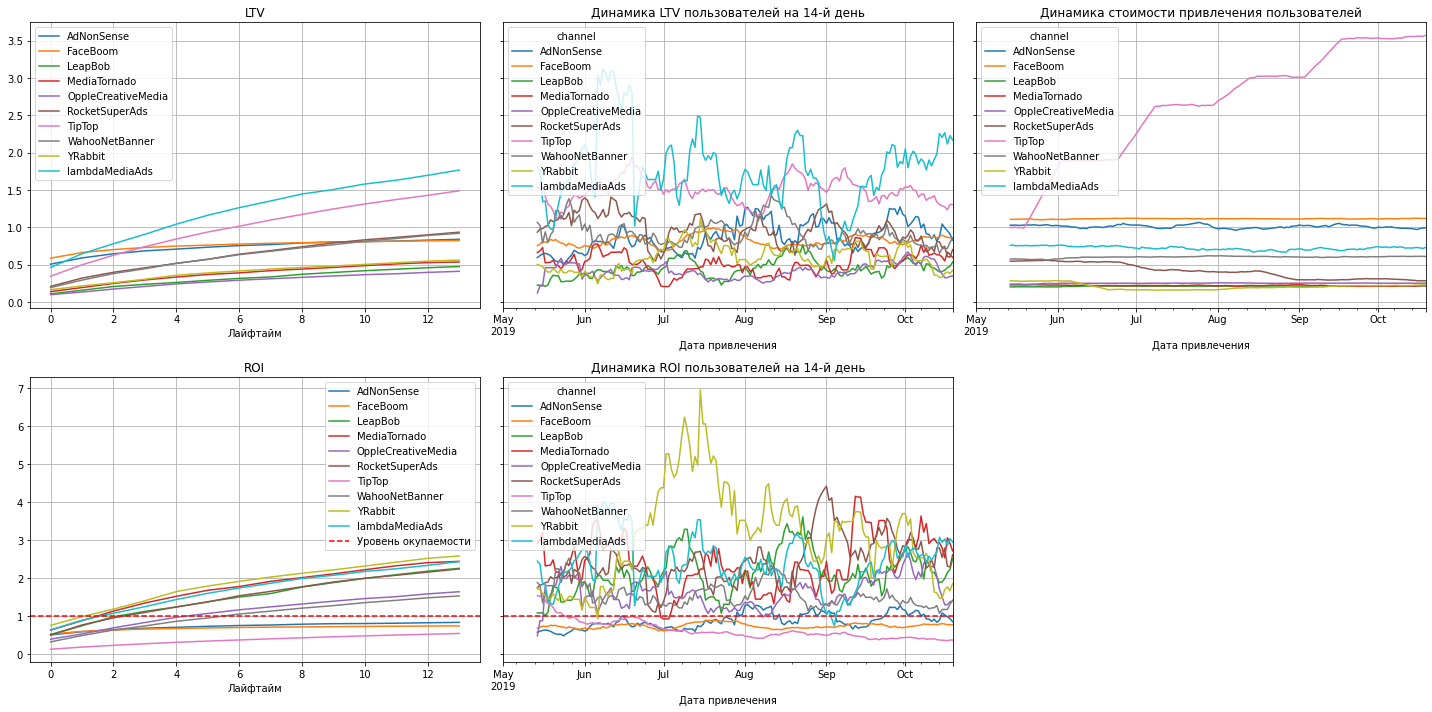

In [41]:
# смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    advertising_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Знакомая картина: чем больше тратим, тем хуже окупается. Компания больше всего ресурсов тартит на рекламу в TipTop, при этом окупается эта реклама хуже всего. Компания так же стабильно тратит бюджет на привлечение пользователей из Faceboom, но и эта реклама не окупается, несмотря на то, что после органических пользователей, пользователей Faceboom компания привлекла больше всего.

Неокупающиеся каналы: TipTop, Faceboom, AdNonSense.

**Посмотрим на конверсию и удержание пользователей**

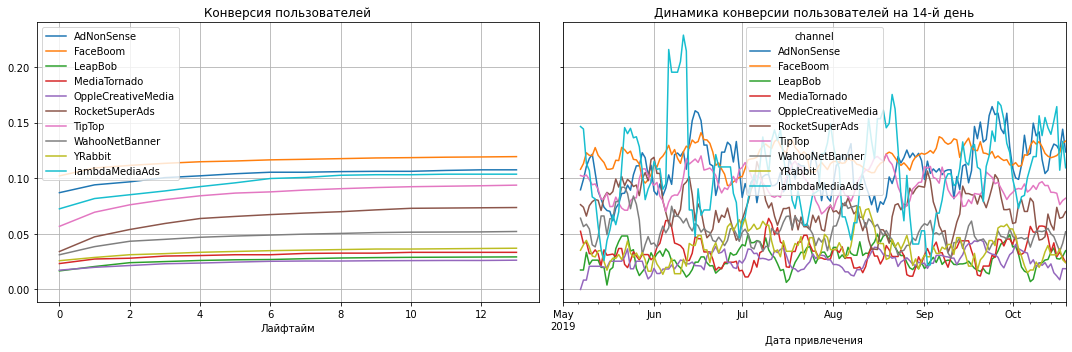

In [42]:
# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    advertising_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Компания больше всего средств тратит на пользователей из рекламного кнанала TipTop, хотя они не так хорошо конвертируются, как Faceboom, AdNonSense, lambdaMediaAds. Целесообразно было бы уменьшить расходы на TipTop и увеличить бюджет на более конвертируемых пользователей.

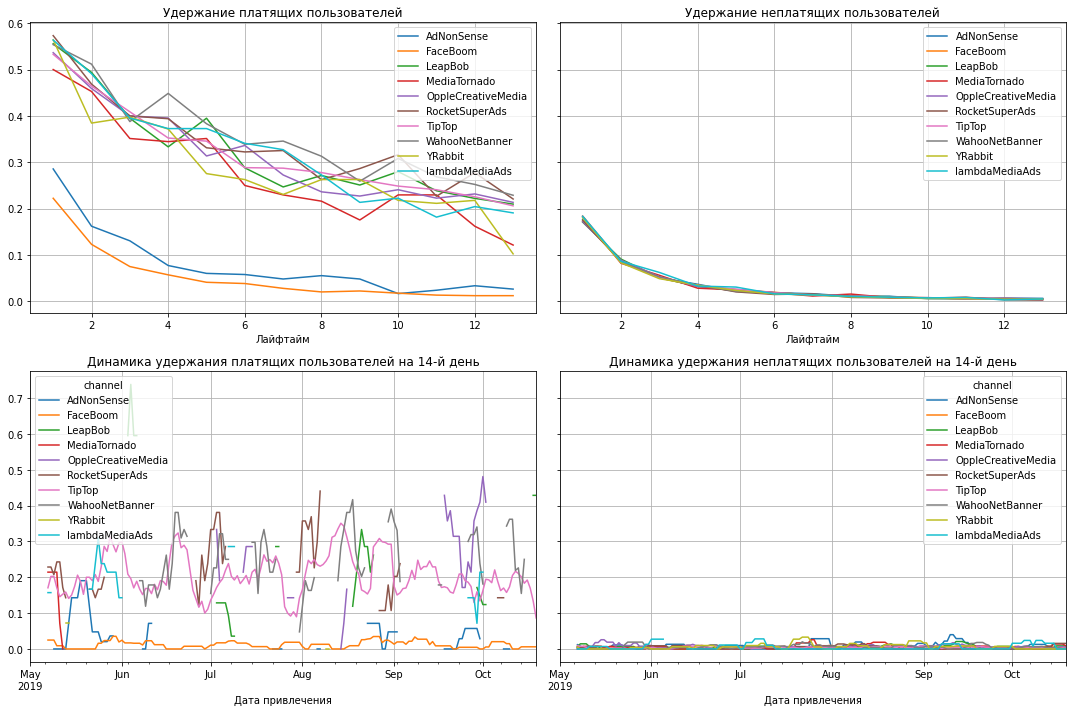

In [43]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    advertising_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Несмотря на хорошую конвертацию пользователей, привлеченных, через Faceboom и AdNonSense, их удержание заметно меньше. Надо проверить на предмет ошибок в сессиях у этих пользователей. Если там все хорошо, то, вероятно, мы просто не попали в целевую аудиторию.

**Посмотрим, какие каналы хорошо окупаются в Америке и в Европе**

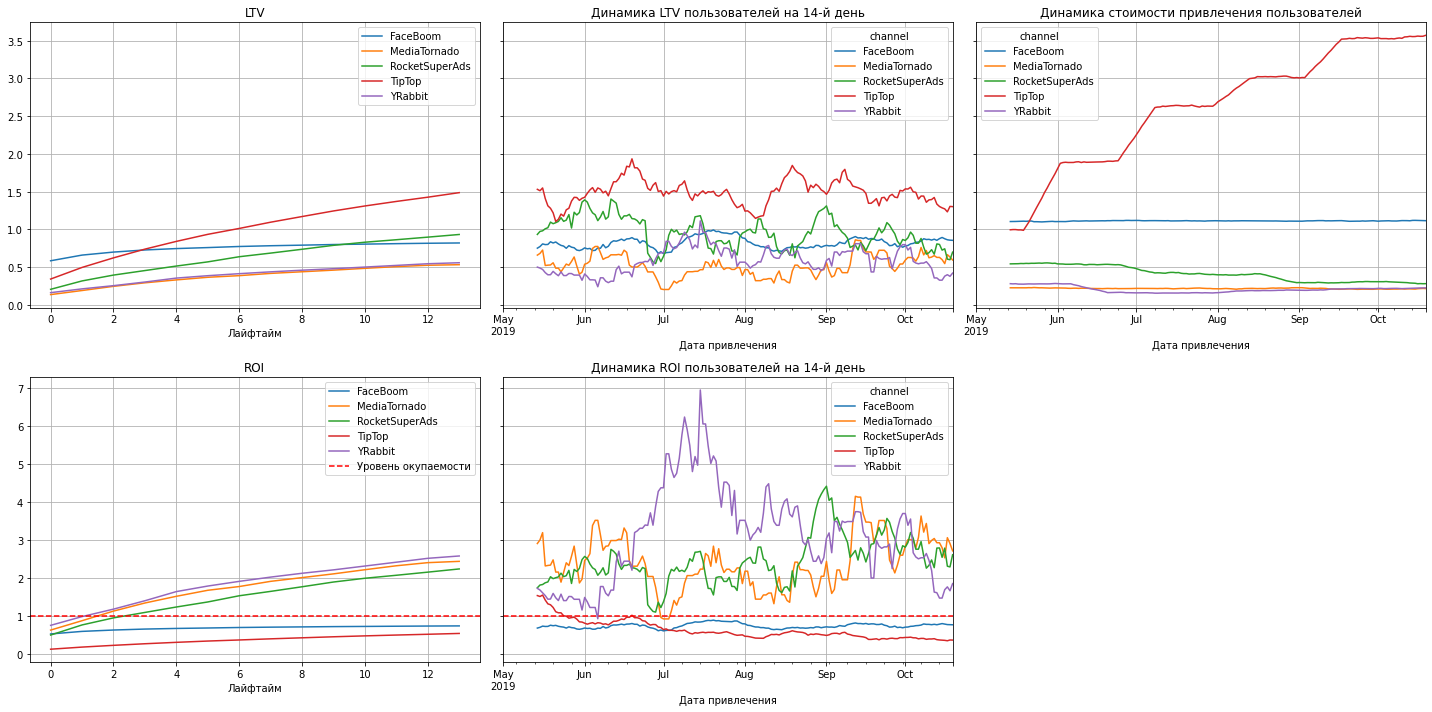

In [44]:
dimensions = ['channel']

# США

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_users, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**В США не окупаются TipTop и Faceboom, окупаются YRabbit, MediaTornado, RocketSuperAds**

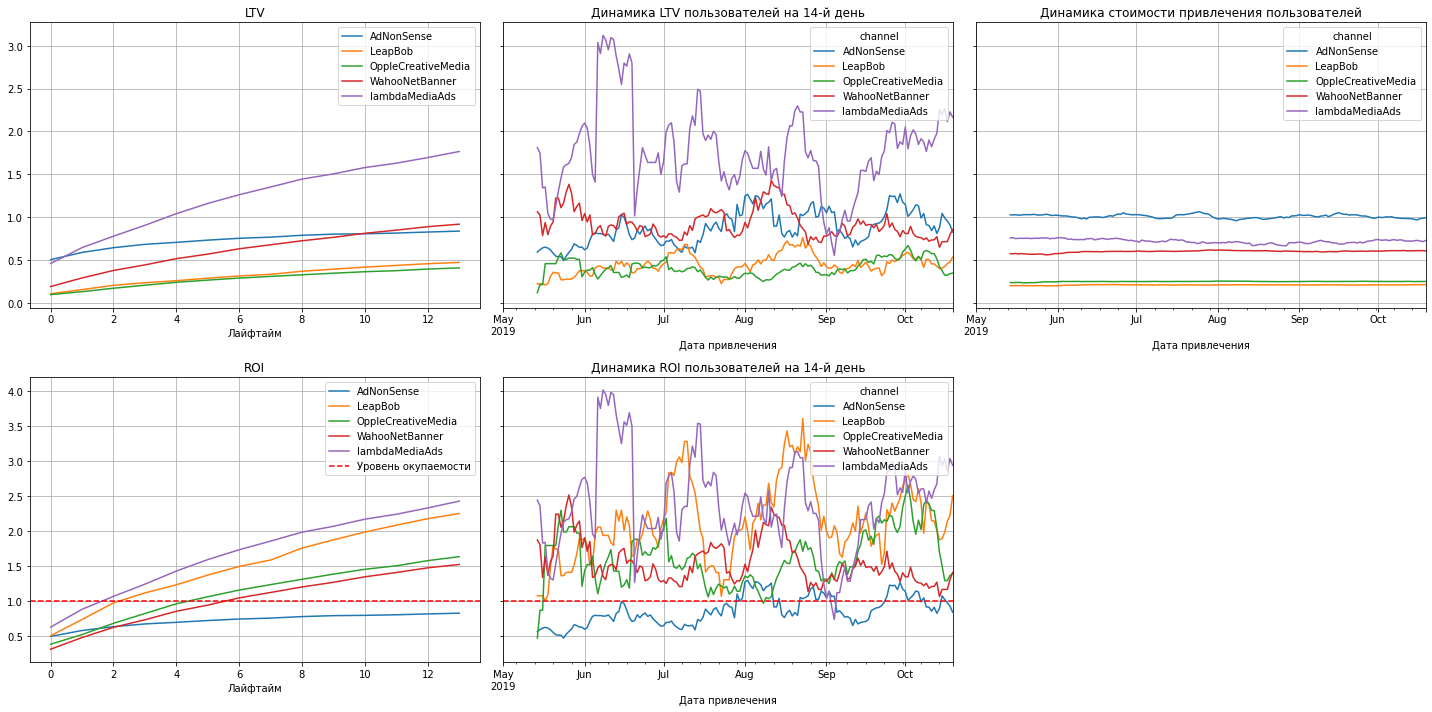

In [45]:
europe_users = advertising_profiles.query('region != "United States"') # выделяем в отдельный датафрэйм пользователей Европы

# Европа

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    europe_users, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**В Европе не окупается AdNonSense, окупаются lambdaMediaAds, LeapBob, OppleCreativeMedia, WahooNetBanner.**

**Выводы по анализу окупаемости рекламы:**

1. В целом реклама, направленная на привлечение пользователей во всех странах, не окупается. ROI достигает 80%, но на протяжении исследуемого периода так и не пересекает границу окупаемости. 
2. Негативное влияние могут оказывать:
      * **устройства**: iPhone и Mac. Затраты на рекламу на пользователей этих устровств больше, а окупаемость меньше.
      * **страны**: США. Большие затраты на привлечение пользователей из США, в сравнении с другими странами, но процент окупаемости и удержания меньше всего.
      * **рекламные каналы**: TipTop - затрарты большие, но окупаемость маленькая. Меньше затраты на Faceboom и AdNonSense, но их удержание меньше всего и именно эти три канала не окупаются.

3. Проблемы в удержании могут быть связаны с техническими настройками и ошибками, интересом пользователей к продукту, стоимости продукта. Возможно, не попали в целевую аудиторию. Всё это необходимо разобрать детально. 

## 6. Общие выводы

Мы провели анализ, чтовы выяснить, почему компания терпит убытки на протяжении последних месяцев. Вот, что нам удалось выяснить:


* **Страны.**
Пользователи в приложение приходят из США, Великобритании, Франции и Германии. Больше всего посетителей и платящих пользователей приходит из США (доля платящих там составляет 6,9%). У Великобритании, Франции и Германии показатели ниже: количество униклальных пользователей в сумме находится в диапазоне от 15 до 17,6к пользователей, а доли платящих пользователей в диапазоне от 3,8 до 4,1%.

Тем не менее, анализ LTV, CAC, ROI, конверсии и удержания показал, что хоть компания и выделяет большие затраты на привлечение пользователей из США, в сравнении с другими странами, процент окупаемости и удержания там **меньше** всего. Пользователи США хорошо конвертируются, но плохо удерживаются. Возможно, возникают **технические ошибки** - например, для пользования приложением необходимо произвести оплату, но оплата именно в этом регионе не проходит. Или же дело в интересе американцев к нашему продукту. А, может, их не устраивает стоимость внутренних покупок, если они есть. Для более детального изучения нам необходим журнал событий.

* **Устройства.** 
Пользователи приложения пользуются iPhone, Android, PC, Mac. По количеству платящих пользователей на первое место выходит iPhone, а если смотреть по долям платящих - Mac.

Затраты на рекламу на пользователей этих устровств больше, а **окупаемость меньше**. Конвертация лучше у пользователей iPhone и Mac, но удерживаются лучше пользователи PC. Возможно, это связано опять же с техническими ошибками (оплата, например) или же приложение не адаптировано под iPhone и Mac.

* **Рекламные каналы.** 
Всего 10 рекламных каналов было задействовано для привлечения пользователей, так же были и органические посетители. Большинство пользователей пришло органически (56к), платящих пользователей было больше всего привлечено с помощью канала Faceboom (12,2%). Меньше всего платящих пользователей пришли органически, но это нормально и ожидаемо. 

В сумме на рекламу было потрачено: 105497. Больше половины общего рекламного бюджета было потрачено на рекламный канал: TipTop (54751), а Faceboom - 32445. С мая по октябрь компания делала упор на привлечение пользователей в TipTop (пик трат на рекламу заметен в сентябре – 13к), примерно 4-5к в среднем тратили на рекламу в Faceboom в течение этого периода. Пользователи TipTop хуже конвертируются и окупаются, целесообразно было бы уменьшить расходы на этот рекламный канал и увеличить бюджет на более конвертируемых пользователей. Например, хорошо конвертируются пользователи, привлеченные Faceboom и AdNonSense, но они не задерживаются долго. Неоходимо проверить, насколько эта аудитория является целевой для нашего продукта. И если все-таки проблема не в ЦА, то, возможно, это связано опять же с техническими настройками/ошибками.

В основном проблемы в удержании пользователей, причины этого могут быть разными.\
\
**Выносим следующие рекомендации для команды маркетинга:**
- Пересмотреть бюджеты каналов привлечения. 
  * **США**: TipTop и Faceboom забирают слишком много денег для привлечения пользователей, но не дают нужных результатов, не окупаются. Перспективные каналы: YRabbit, MediaTornado, RocketSuperAds.
  * **Европа**: AdNonSense не окупается на привлечении пользователей. Перспективные каналы: lambdaMediaAds, LeapBob, OppleCreativeMedia, WahooNetBanner.
- Пересмотреть ЦА по каналам привлечения и странам. Верно ли настроена реклама? Может, она показывается не тем людям? Обратить особое внимание на пользователей США - актуальна ли для них реклама, или они устанавливают приложение из любопытства и потом уходят?
- Обратиться к команде программистов/дизайнеров/тестировщиков, чтобы узнать, всё ли хорошо с настройками приложения для Apple (iPhone и Mac). Так же необходимо проверить приложение на предмет технических сбоев (работает ли оплата у пользователей Apple и жителей США).